## Understanding Hive Partitioning
Reference: https://www.youtube.com/watch?v=fZndmQasykk

In [33]:
from pyspark.sql import SparkSession

# Initialize Spark Session
spark = SparkSession.builder.appName("partitioning").getOrCreate()
sc = spark.sparkContext

In [16]:
listening_df = spark.read.csv("../data/partitioning/raw/Spotify_Listening_Activity.csv", header=True, inferSchema=True)
listening_df.show(10, False)

+-----------+-------+--------------------------+---------------+
|activity_id|song_id|listen_date               |listen_duration|
+-----------+-------+--------------------------+---------------+
|1          |12     |2023-06-27 10:15:47.008867|69             |
|2          |44     |2023-06-27 10:15:47.008867|300            |
|3          |75     |2023-06-27 10:15:47.008867|73             |
|4          |48     |2023-06-27 10:15:47.008867|105            |
|5          |10     |2023-06-27 10:15:47.008867|229            |
|6          |82     |2023-06-27 10:15:47.008867|35             |
|7          |64     |2023-06-27 10:15:47.008867|249            |
|8          |96     |2023-06-27 10:15:47.008867|211            |
|9          |52     |2023-06-27 10:15:47.008867|99             |
|10         |21     |2023-06-27 10:15:47.008867|181            |
+-----------+-------+--------------------------+---------------+
only showing top 10 rows



In [17]:
from pyspark.sql.functions import * 

listening_df = (
    listening_df
    .withColumnRenamed("listen_date", "listen_time")
    .withColumn("listen_date", to_date("listen_time", "yyyy-MM-dd HH:mm:ss.SSSSSS"))
    .withColumn("listen_hour", hour("listen_time"))
)

listening_df.show(5, False)
listening_df.printSchema()
listening_df.count()

+-----------+-------+--------------------------+---------------+-----------+-----------+
|activity_id|song_id|listen_time               |listen_duration|listen_date|listen_hour|
+-----------+-------+--------------------------+---------------+-----------+-----------+
|1          |12     |2023-06-27 10:15:47.008867|69             |2023-06-27 |10         |
|2          |44     |2023-06-27 10:15:47.008867|300            |2023-06-27 |10         |
|3          |75     |2023-06-27 10:15:47.008867|73             |2023-06-27 |10         |
|4          |48     |2023-06-27 10:15:47.008867|105            |2023-06-27 |10         |
|5          |10     |2023-06-27 10:15:47.008867|229            |2023-06-27 |10         |
+-----------+-------+--------------------------+---------------+-----------+-----------+
only showing top 5 rows

root
 |-- activity_id: integer (nullable = true)
 |-- song_id: integer (nullable = true)
 |-- listen_time: timestamp (nullable = true)
 |-- listen_duration: integer (nullable

11779

### Partitioning by listen_date

In [18]:
listening_df.write.partitionBy('listen_date').mode('overwrite').parquet('../data/partitioning/partitioned/Spotify_Listening_Activity_1')

In [19]:
listening_df_pruned = spark.read.parquet("../data/partitioning/partitioned/Spotify_Listening_Activity_1")
listening_df_pruned.filter("listen_date = '2019-01-01'").explain()

== Physical Plan ==
*(1) ColumnarToRow
+- FileScan parquet [activity_id#494,song_id#495,listen_time#496,listen_duration#497,listen_hour#498,listen_date#499] Batched: true, DataFilters: [], Format: Parquet, Location: InMemoryFileIndex(1 paths)[file:/Users/saitejadevalla/Desktop/SaiTeja/GitHub_Repos/All_things_Spa..., PartitionFilters: [isnotnull(listen_date#499), (listen_date#499 = 2019-01-01)], PushedFilters: [], ReadSchema: struct<activity_id:int,song_id:int,listen_time:timestamp,listen_duration:int,listen_hour:int>




### Multilevel partitioning

In [ ]:
listening_df.write.partitionBy('listen_date','listen_hour').mode('overwrite').parquet('../data/partitioning/partitioned/Spotify_Listening_Activity_2')

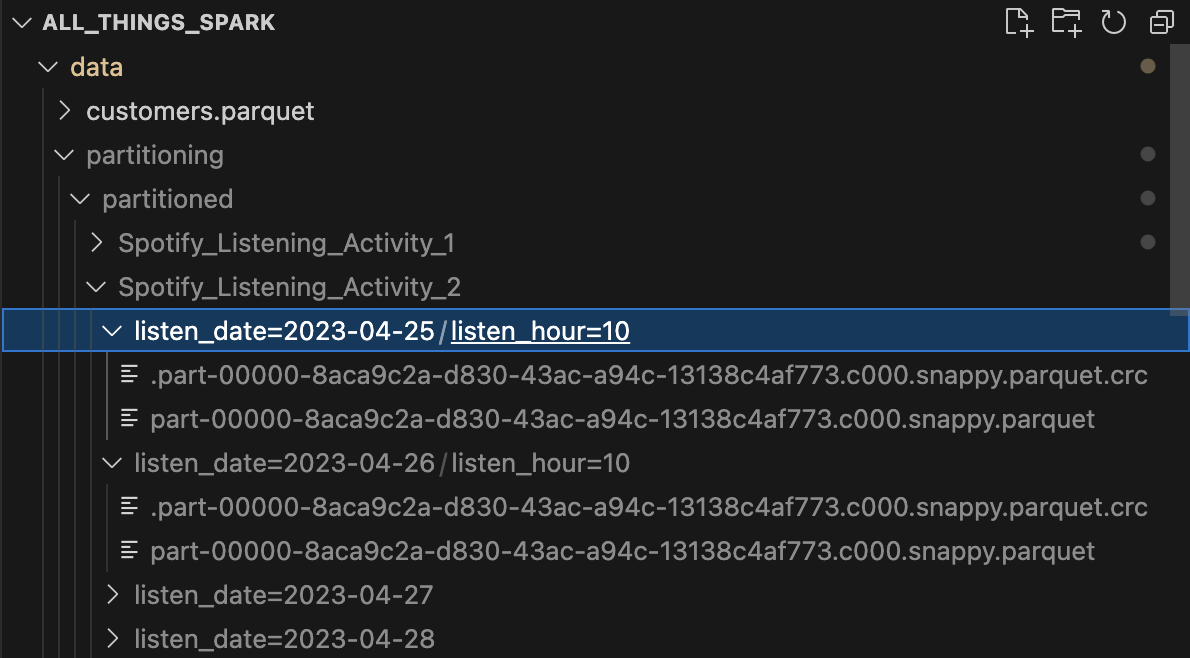

In [28]:
from IPython.display import Image
Image(filename='../UI_screenshots/partitioning/Mlp-1.png',width=500,height=3)

In [ ]:
listening_df.write.partitionBy('listen_hour','listen_date').mode('overwrite').parquet('../data/partitioning/partitioned/Spotify_Listening_Activity_3')

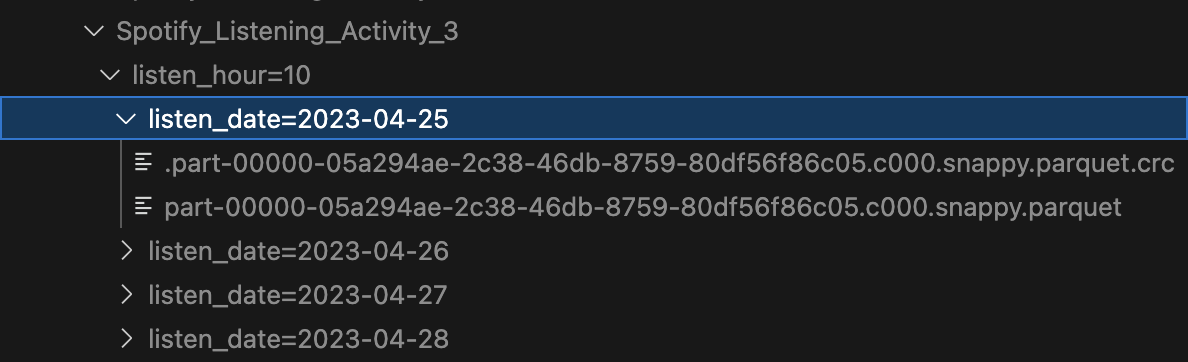

In [29]:
from IPython.display import Image
Image(filename='../UI_screenshots/partitioning/Mlp-2.png',width=500,height=3)

### Repartitioning

In [ ]:
listening_df.repartition(4).write.partitionBy('listen_date').mode('overwrite').parquet('../data/partitioning/partitioned/Spotify_Listening_Activity_4')

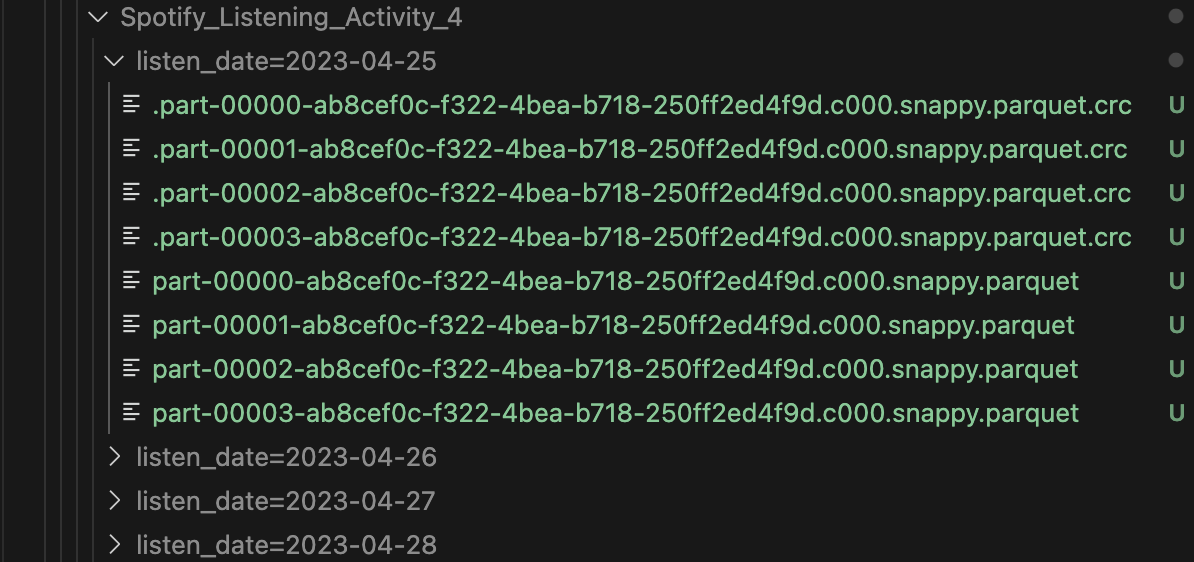

In [30]:
from IPython.display import Image
Image(filename='../UI_screenshots/partitioning/rep.png',width=500,height=3)

### Coalesce

In [ ]:
listening_df.coalesce(2).write.partitionBy('listen_date','listen_hour').mode('overwrite').parquet('../data/partitioning/partitioned/Spotify_Listening_Activity_5')

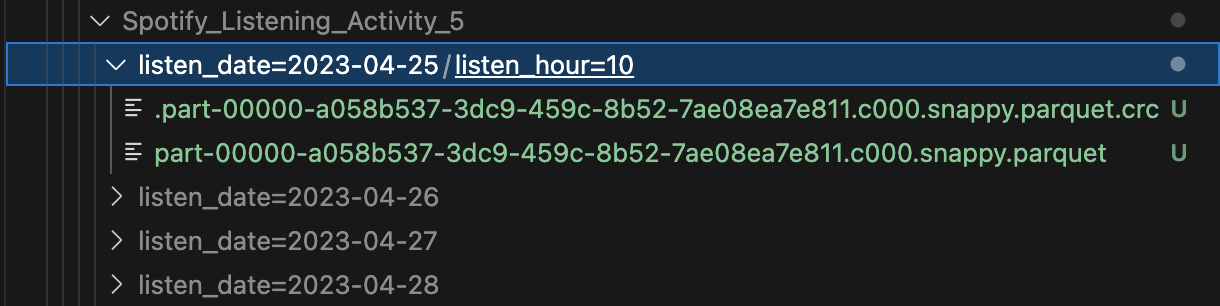

In [31]:
from IPython.display import Image
Image(filename='../UI_screenshots/partitioning/coal.png',width=500,height=3)

### Understanding spark.sql.files.maxPartitionBytes

In [34]:
df = spark.read.csv("../data/partitioning/raw/Spotify_Listening_Activity.csv", header=True, inferSchema=True)
df.rdd.getNumPartitions()

1

In [36]:
spark.conf.set("spark.sql.files.maxPartitionBytes", "1000")

df_modified = spark.read.csv("../data/partitioning/raw/Spotify_Listening_Activity.csv", header=True, inferSchema=True)
df_modified.rdd.getNumPartitions()

457

In [37]:
spark.stop()